<a href="https://colab.research.google.com/github/showerju/TextMining/blob/master/finial_05_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **네이버 영화 리뷰 분류기**
Google colab 사용

---
### **사용패키지**



konlpy 다운로드

In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 35.0MB/s 
     |████████████████████████████████| 92kB 9.4MB/s 
     |████████████████████████████████| 460kB 42.3MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression # 로지스틱 회귀분석
from sklearn.model_selection import GridSearchCV # 하이퍼 파라미터 최적화 ( 유튜브 도움 )
import requests
import time

from konlpy.tag import Okt


okt = Okt()
okt.morphs('죽겠다 정말')

['죽겠다', '정말']

### **평점, 리뷰 크롤링**

---
**별점, 댓글, 댓글에 대한 공감수, 비공감수를 데이터로 가져오기**


In [3]:
review_set=[]
score_set=[]
good_set=[]
bad_set=[]
tokenizer_re=[]
for i in range (1,3600):
    time.sleep(1)
    url = 'https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=161967&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page='+str(i)
    result = requests.get(url)
    soup = BeautifulSoup(result.text, 'html.parser')
    review_all = soup.find('div', class_='score_result')

    for li in review_all.find_all('li'):
      a1=li.em.text
      a2=li.p.text
      a3=li.find("div", class_ = "btn_area").find_all("strong")[0].get_text()
      a4=li.find("div", class_ = "btn_area").find_all("strong")[1].get_text()
      score = ' '.join(a1.split())   
      reviews = ' '.join(a2.split()) 
      good=' '.join(a3.split())
      bad=' '.join(a4.split())

      print('별점 : ',score)
      print('댓글 : ',reviews)
      print("좋아요 : ",good)
      print("별로에요",bad)
      print(" ")

      review_set.append(reviews)
      score_set.append(score)
      good_set.append(good)
      bad_set.append(bad)

      token= okt.morphs(reviews)
      tokenizer_re.extend(token)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
별점 :  9
댓글 :  마지막까지 어떤 일이 일어날지 예측 할 수 없는 영화.
좋아요 :  1
별로에요 6
 
별점 :  10
댓글 :  
좋아요 :  1
별로에요 6
 
별점 :  10
댓글 :  재밌게.잘.봤습니다.
좋아요 :  1
별로에요 6
 
별점 :  10
댓글 :  영화 보는 내내 불편한 마음...
좋아요 :  1
별로에요 6
 
별점 :  8
댓글 :  스토리가 영화관이란 적은 공간을 대비하여 울림이 큽니다. 배우들이 주어진 역할에 대한 흡입도가 있습니다. 보여지는 내용보다, 은닉된 장면들, 실제의 대사보다 그 대사가 울리는 공간이 스크린이란 공간을 넘고, 관객의 ...
좋아요 :  1
별로에요 6
 
별점 :  10
댓글 :  참 씁쓸한 영화 탄탄한 스토리와 흥미로운 전개
좋아요 :  1
별로에요 6
 
별점 :  10
댓글 :  영화와 감독등 관계자 모두에게 리스펙~!!
좋아요 :  1
별로에요 6
 
별점 :  10
댓글 :  인생영화 등록 여운이 길게 남는 영화였다 ~~!
좋아요 :  1
별로에요 6
 
별점 :  10
댓글 :  감독상 받을 때 송강호가 봉감독 뺨 엄청 만질 때 호구 하나 제대로 담구는 거처럼 보였습니다. 아무리 친해도 선을 넘는 송강호 보고 앞으로 할리우드 배우들 중 캐스팅 될 때 봉감독 쉽게 생각하지 않았으면 좋겠네요.
좋아요 :  1
별로에요 6
 
별점 :  10
댓글 :  기생충 영화 재밌는데 신음소리 나오네요 조여정 배우님 마약사달라고 신음소리 나오네요 잔인하게 사람죽이는 장면도 나오네요 볼만한 영화네요
좋아요 :  1
별로에요 6
 
별점 :  10
댓글 :  무슨 말이 필요한가. 역대 최고의 영화
좋아요 :  1
별로에요 6
 
별점 :  10
댓글 :  드라마인데 모든 장르가 들어가있다. 수상을 받을만한 가치를 보여주는 현대작품.
좋아요 :  1
별로에요 6
 
별점 :  10
댓글 :  가장 봉준호적인 것이 가장 오스카적인 것이다
좋아요 

### **PANDAS를 통한 데이터프레임(CSV) 생성**

---
* **데이터프레임 속 데이터에 결측치가 있는지 확인하기**


In [4]:
##불러온 데이터를 pandas를 통해 frame만들기
df = pd.DataFrame([score_set, review_set,good_set,bad_set]).T
df.columns = ['score','review','good','bad']

##결측치 확인하기
df.isnull()

score  review   good    bad
0      False   False  False  False
1      False   False  False  False
2      False   False  False  False
3      False   False  False  False
4      False   False  False  False
...      ...     ...    ...    ...
35985  False   False  False  False
35986  False   False  False  False
35987  False   False  False  False
35988  False   False  False  False
35989  False   False  False  False

[35990 rows x 4 columns]

In [5]:
df.isnull().sum()
##결측치가 없음확인

score     0
review    0
good      0
bad       0
dtype: int64

###**데이터 정보 보기**
 - **통계**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35990 entries, 0 to 35989
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   score   35990 non-null  object
 1   review  35990 non-null  object
 2   good    35990 non-null  object
 3   bad     35990 non-null  object
dtypes: object(4)
memory usage: 1.1+ MB


In [7]:
df.describe()
#pandas 출력

score review   good    bad
count   35990  35990  35990  35990
unique     10  35134    320    164
top        10             1      1
freq    22850    683   8386   8235

###**'리뷰의 길이' 열 추가하기**

In [8]:
df['review_length']=df['review'].apply(len)
df.head()

score                                             review  ...   bad review_length
0    10         비에 젖지 않는 고급 장난감 텐트와, 비에 젖다 못해 잠겨버리는 반지하 가구  ...  1530            42
1    10  최근 본 영화중 가장 충격적이었음... 근데 보니까 15세말고 19세 걸어야될것같던데..  ...  1640            49
2    10    지하철이라는 단어가 언급되는 순간, 대다수의 관객은 자신이 어디에 이입할 지를 안다.  ...  1139            47
3    10       전 가정부가 집 벨 누를 때 부터 이 영화는 장르가 바뀐다... 역대급 꿀잼영화  ...   952            44
4    10                 황금종려상 수상작을 자막 없이 볼 수 있다는 것 자체로 좋다.  ...   816            34

[5 rows x 5 columns]

In [9]:
##review_lingth 값을 통계값으로 보기
df['review_length'].describe()

count    35990.000000
mean        41.862017
std         32.530470
min          0.000000
25%         18.000000
50%         29.000000
75%         55.000000
max        152.000000
Name: review_length, dtype: float64

### **CSV 파일 저장**

---
* **Colab의 구글 드라이브 마운트 필요**

* **생성된 파일은 우선 메모장으로 열어서 형식변경필요 (UTF-8 >>>> ANSI 로 변경)**

In [10]:
#from google.colab import drive
#drive.mount('/content/drive')

In [11]:
#df.to_csv('/content/drive/MyDrive/Colab Notebooks/review.csv')


##**기계학습**
---

### **트레이닝 / 테스트 분리 실행**

*   **train:test 비율 = 8:2**




In [12]:
train_x, test_x, train_y, test_y = train_test_split(review_set, score_set, test_size=0.2, random_state=1)
len(train_x),len(train_y)

(28792, 28792)

### **트레이닝 _ SET**
### **Vectorizer**
---

*   **tokenizer = okt (konlpy -> Twitter 사용)**
*   **ngram = 1,2 사용 (1~2단어) min,max_df -> 빈도수 컷 (2개 이하의 단어 / 50%이상 출현하는 단어 컷)**


In [13]:
tfv = TfidfVectorizer(tokenizer_re, ngram_range=(1,2), min_df=2, max_df=0.50)
#학습 시작
tfv.fit(train_x)
#학습 적용
tfv_train_x=tfv.transform(train_x)

In [14]:
#토큰확인
#tokenizer_re

**학습 결과**

In [15]:
tfv_train_x

<28792x32330 sparse matrix of type '<class 'numpy.float64'>'
	with 248871 stored elements in Compressed Sparse Row format>

### **분류 알고리즘**

---
* **유튜브 영상 참고 코드 포함**
* **오류뜨면 max_iter 올려볼 것 (초기값 100이었음) -은빈**

In [16]:
clf = LogisticRegression(random_state=1,max_iter=1000)
params = {'C':[1,3,5,7,9]} # 유튜브 도움
grid_cv = GridSearchCV(clf, param_grid=params, cv=4, scoring='accuracy', verbose=1)
grid_cv.fit(tfv_train_x, train_y)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 13.2min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=1, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None, param_grid={'C': [1, 3, 5, 7, 9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

**가장 적합한 파라미터**

In [17]:
grid_cv.best_params_ 

{'C': 3}

### **트레이닝 _ SET 정확도**

In [18]:
grid_cv.best_score_ * 100

64.23312031119755

### **테스트 _ SET 정확도**
---

In [19]:
tfv_test_x = tfv.transform(test_x)
grid_cv.best_estimator_.score(tfv_test_x,test_y) * 100

64.3651014170603

###**동작확인**
---
* **각 문단 별 주석처리 해서 사용**
* **Input text에 재미없음을 입력해보세요~**

In [24]:
##1번 set = 테스트

#text = ['재밌어요','말이 필요없다. 최고의 영화','올해 최악의 영화','뭐 이딴걸 영화라고','노잼','재미없음','감사합니다.']
#testing = tfv.transform(text)
#result=grid_cv.best_estimator_.predict(testing)
#result

#------------------------------------------------------------------------------------------------------------------------------#

## 2번 set = 완성형

text = input('리뷰를 입력해주세요 : ')
testing = tfv.transform([text])
result=grid_cv.best_estimator_.predict(testing)
result

if result == ['1'] :
  print(f'["{text}"] -> 부정적인 리뷰입니다.')
elif result == ['2']:
   print(f'["{text}"] -> 부정적인 리뷰입니다.')
elif result == ['3']:
   print(f'["{text}"] -> 부정적인 리뷰입니다.')
elif result == ['4']:
   print(f'["{text}"] -> 부정적인 리뷰입니다.')
else : 
  print(f'["{text}"] -> 긍정적인 리뷰입니다.')


리뷰를 입력해주세요 : 내 생 최악의 영화다. 이걸 왜보는 건지?
["내 생 최악의 영화다. 이걸 왜보는 건지?"] -> 부정적인 리뷰입니다.


## **시각화**

###**시각화 처리 1**###
---
**별점에 따른 리뷰길이의 관계를 알아보기 위해 차트로 표현하기**

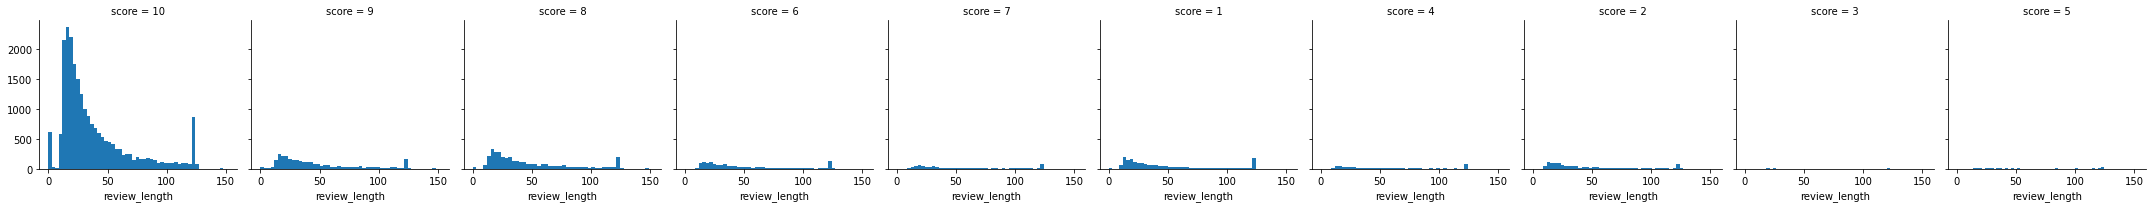

In [ ]:
## 별점에 따른 텍스트 길이 시각화
g=sns.FacetGrid(data=df, col='score')
g.map(plt.hist,'review_length', bins=50)

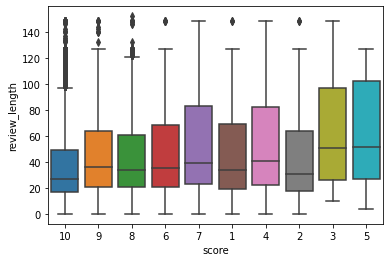

In [ ]:
## 별점에 따른 텍스트 길이 boxplot으로 시각화
## min, mean, max 값이 box형태로 시각화 
sns.boxplot(x='score',y='review_length', data=df)

* **위 시각화를 통해서 텍스트 길이가 score가 중간정도에 위치 할수록 review의 길이의 최대 길이가 길다는 것을 알 수 있다.**
* **score의 중간정도에 위치 할 수록 평균길이가 길다는 것을 알 수 있다.** 

###**시각화 처리 2**
---
**리뷰 길이와 다른 user의 그 리뷰에 대한 평가(좋아요, 별로에요)의 상관관계를 알아보기**

In [ ]:
##상관관계를 보기
score=df.groupby('score').mean()
score.corr()

good       bad  review_length
good           1.000000  0.165495      -0.726801
bad            0.165495  1.000000       0.048438
review_length -0.726801  0.048438       1.000000

* **데이터의 score, 리뷰 평가(좋아요, 별로에요) 갯수가 정수형이 아닌것을 알았다.**

In [ ]:
#pandas의 형변환 기능을 통해 열의 값들의 정수형으로 전환하고, score값을 기준으로 그룹핑해본다.
df['score']=pd.to_numeric(df['score'])
df['good']=pd.to_numeric(df['good'])
df['bad']=pd.to_numeric(df['bad'])
score=df.groupby('score').mean()

In [ ]:
score

good        bad  review_length
score                                     
1      19.789474  11.029791      48.147964
2      12.102543   7.141920      45.643970
3       9.869565   5.791304      62.417391
4       9.254400   5.606400      53.841600
5       6.690000   4.286667      62.966667
6      10.508941   4.471802      49.328061
7       8.923655   3.092616      54.066333
8      21.688351   3.474562      46.115374
9      15.701028   2.707325      47.108717
10     17.885427   3.186389      38.133873

* **score의 점수에 따른 공감수와 비공감 수의 평균을 알아본다.**
* **score의 점수가 10점,8점,9점의 순으로 공감수가 많게 나왔다.**

In [ ]:
##다시 상관관계를 보기
score.corr()

good       bad  review_length
good           1.000000  0.165495      -0.726801
bad            0.165495  1.000000       0.048438
review_length -0.726801  0.048438       1.000000

* **공감수와 비공감수 사이에는 상관관계가 있는 것으로 보인다.**
* **리뷰 길이는 공감수와, 비공감수와 음의 상관관계가 있는 것으로 보인다.**

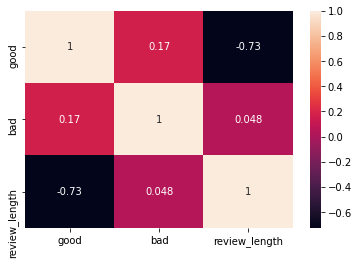

In [ ]:
#heatmap을 통해 시각화 : 공감수와 비공감수 사이에는 상관관계가 있는 모습을 시각화 했다. 
sns.heatmap(data=score.corr(), annot=True)

###**시각화 처리 3**
---
**review 빈도수가 많은 단어를 가지고 wordCloud 만들기**

In [ ]:
from wordcloud import WordCloud,STOPWORDS

In [ ]:
##pandas data frame 자료를 numpy를 이용하여 array로 변환
np.array(df['review'].tolist())

array(['비에 젖지 않는 고급 장난감 텐트와, 비에 젖다 못해 잠겨버리는 반지하 가구',
       '최근 본 영화중 가장 충격적이었음... 근데 보니까 15세말고 19세 걸어야될것같던데..',
       '지하철이라는 단어가 언급되는 순간, 대다수의 관객은 자신이 어디에 이입할 지를 안다.', ...,
       '킁킁 좌좀냄새안나냐?',
       '관개구새기들 평론가 인척 말만 번지르르하게 하는거 오지네 ㅋㅋㅋ 정작 평론의 ㅍ자도 모르는 것들이 십 ㅋㅋㅋ 알바새기들 도랏나 ㄹㅇ',
       '봉감독 실망! 이런걸 상주다니'], dtype='<U152')

In [ ]:
## numpy를 통해 list 타입으로 변환
review_list=list(np.array(df['review'].tolist()))

In [ ]:
## list 타입을 문자형으로 변환
review_list="".join(review_list)
review_list

'비에 젖지 않는 고급 장난감 텐트와, 비에 젖다 못해 잠겨버리는 반지하 가구최근 본 영화중 가장 충격적이었음... 근데 보니까 15세말고 19세 걸어야될것같던데..지하철이라는 단어가 언급되는 순간, 대다수의 관객은 자신이 어디에 이입할 지를 안다.전 가정부가 집 벨 누를 때 부터 이 영화는 장르가 바뀐다... 역대급 꿀잼영화황금종려상 수상작을 자막 없이 볼 수 있다는 것 자체로 좋다.반지하가 제일 아래인줄 알았다. 내려가보니 지하도 있었다.뭔가 모를 불쾌한 영화였다. 영화가 불쾌하다는게 아니라 보는 내내 가슴에 뭔가 영화에서 나오는 수석이 얹혀져있는 영화다.관람객 나 또한 누군가의 사람 사는 냄새에 얼굴 찌푸리진 않았었나..누군가의 냄새를 맡고, 평가하고, 묘사할 수 있는 것 또한 권력. 냄새로 서로를 알아보고 경계하고 구분짓는 동물들의 세계와 우리 사회는 참 닮아있다.박서준이 잘못했네ㅋㅋㅋㅋ봉테일이 간과한 것 - 납골당은 눈높이에 있는 곳이 가장 비쌉니다. 죽음에도 빈부격차가 있어요.등급조정이 필요해보입니다. 청소년들은 감당하기 버거운 내용이에요.막판에 나오는 기우의 바램은 이루어지지 않겠지.. 계획하면 계획대로 안되니까누군가는 쏟아져 내리는 빗물을 장난감 텐트로도 막을 수 있지만 다른 누군가에게는 똥구정물이 되어 차오른다. ‘계획’만으로는 올라갈 수 없는 우리네 사회구조의 냉혹하고도 잔인한 현실이 세련된 연출력으로 수석처럼 무겁게...갑에게 감사하며 을들끼리 싸웁니다. 우리사회의 축소판박사장은 기택의 냄새에 대해서는 언급하지만 기우와 기정과의 냄새에 대해 언급하지 않는다. 기우와 기정은 명문 교육을 받은 자기와 같은 선상에 설 수 있는 사람이라고 인식했고 기택은 하등한 사람이라고 인식했기때문에.....사이다를 기대했는데 소주 세 잔을 얻어마신 기분이다. 첫번째 잔은 즐겁고, 두번째 잔은 어지럽고, 세번째 잔은 너무 쓰네..인디언 추장 모자쓴 송강호의 표정이 이영화 모두를 담아낸다관람객 누군가는 집을 잃고 모든 재산을 잃는 어마어마한 홍수가,누구에게는 그저

In [ ]:
## 정규표현식을 사용하여 특수문자 제거하고, 공백을 기준으로 문장 자르기(단어화하기)
import re
review_list=re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', ' ', review_list)
# words=review_list.split(" ")
# words

In [ ]:
Okt_morphs = okt.pos(review_list)  # 튜플반환
print(Okt_morphs)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
Noun_words = []
for word, pos in Okt_morphs:
    if pos == 'Noun':
        Noun_words.append(word)
print(Noun_words)

['비', '고급', '장난감', '텐트', '비', '반지하', '가구', '최근', '영화', '가장', '충격', '보', '세', '세', '지하철', '단어', '언급', '순간', '대다수', '관객', '자신', '어디', '이입', '전', '가정부', '집', '벨', '때', '부터', '이', '영화', '장르', '역대', '꿀잼', '영화', '황금종려상', '수상작', '자막', '볼', '수', '것', '자체', '반지하', '제일', '아래', '줄', '지하도', '뭔가', '영화', '영화', '내내', '가슴', '뭔가', '영화', '수석', '영화', '관람객', '나', '또한', '누군가', '사람', '냄새', '얼굴', '누군가', '냄새', '평가', '묘사', '수', '것', '또한', '권력', '냄새', '서로', '경계', '구분', '동물', '세계', '우리', '사회', '박서준', '봉테', '일이', '간과', '것', '납골당', '눈높이', '곳', '가장', '죽음', '빈부격차', '등급', '정이', '청소년', '감당', '버거운', '내용', '막판', '기우', '바램', '계획', '계획', '누군가', '빗물', '장난감', '텐트', '도', '막', '수', '다른', '누군가', '똥', '정물', '계획', '수', '우리네', '사회', '구조', '냉혹', '현실', '연출', '수석', '갑', '끼리', '우리', '사회', '축소', '판', '박사', '기택', '냄새', '대해', '언급', '기우', '기정', '냄새', '대해', '언급', '기우', '기정은', '명문', '교육', '자기', '선상', '설', '수', '사람', '인식', '기택', '하등', '사람', '인식', '때문', '사이다', '소주', '세', '잔', '기분', '첫', '잔', '두번째', '잔', '세번', '잔', '인디언', '추장', '모자', '송강호', '

In [ ]:
stopwords = ['정말', '처음','계속','다시','연기','봉준호','장면','평점','뭔가','내내','사람','시간','모두','우리','작품','장르','하나','영화', '관람객', '것','거','이','나','또','한번','그','진짜','그것','전''봉준호','송강호','해도','스토리','배우','블랙','코미디','감독','보고','칸','상','그냥','아주','다음','먼저','아니','듯이','데','기생충']
unique_Noun_words = set(Noun_words)
for word in unique_Noun_words:
    if word in stopwords:
        while word in Noun_words: Noun_words.remove(word)

In [ ]:
from collections import Counter
c = Counter(Noun_words)
print(c.most_common()) # 상위 10개 출력하기

[('생각', 3729), ('최고', 1856), ('수', 1580), ('현실', 1575), ('말', 1460), ('더', 1313), ('기분', 1296), ('냄새', 1227), ('왜', 1176), ('충격', 1121), ('가족', 1117), ('내', 1080), ('재미', 983), ('사회', 976), ('점', 975), ('역시', 914), ('때', 908), ('느낌', 884), ('볼', 846), ('계획', 828), ('내용', 815), ('좀', 794), ('여운', 792), ('연출', 685), ('집', 673), ('보기', 672), ('돈', 660), ('세', 651), ('정도', 639), ('의미', 628), ('이해', 620), ('듯', 616), ('표현', 616), ('몰입', 611), ('한국', 601), ('마음', 592), ('인생', 589), ('부자', 583), ('번', 582), ('꼭', 578), ('봉', 573), ('끝', 564), ('반지하', 554), ('마지막', 553), ('관람', 540), ('황금종려상', 539), ('한국영', 535), ('평', 526), ('가장', 489), ('안', 488), ('소름', 487), ('조여정', 484), ('기대', 473), ('만', 471), ('이야기', 464), ('임', 463), ('난', 456), ('속', 453), ('가난', 452), ('감상', 447), ('뭐', 447), ('모든', 446), ('감', 441), ('삶', 432), ('후', 424), ('못', 423), ('천재', 420), ('걸', 419), ('인간', 417), ('전개', 417), ('선', 413), ('가슴', 406), ('반전', 406), ('중', 403), ('별로', 398), ('때문', 392), ('저', 392), ('결말', 391

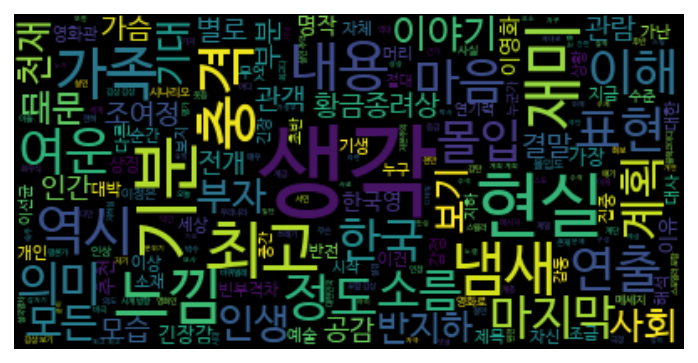

In [ ]:
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from os import path

fontpath= '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

%config InlineBackend.figure_format='retina'
!apt -qq -y install fonts-nanum > /dev/null

noun_text = ''
for word in Noun_words:
    noun_text = noun_text +' '+word

wordcloud = WordCloud(max_font_size=60, relative_scaling=.5, font_path = fontpath ).generate(noun_text) # generate() 는 하나의 string value를 입력 받음
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
